<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Columns" data-toc-modified-id="Columns-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Columns</a></span><ul class="toc-item"><li><span><a href="#majortopic" data-toc-modified-id="majortopic-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>majortopic</a></span></li><li><span><a href="#subtopic" data-toc-modified-id="subtopic-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>subtopic</a></span></li><li><span><a href="#bill-titles" data-toc-modified-id="bill-titles-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>bill titles</a></span></li></ul></li><li><span><a href="#Prepare-for-model---tokenize" data-toc-modified-id="Prepare-for-model---tokenize-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Prepare for model - tokenize</a></span></li></ul></li><li><span><a href="#Model---Bag-of-Words" data-toc-modified-id="Model---Bag-of-Words-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model - Bag of Words</a></span><ul class="toc-item"><li><span><a href="#Metric" data-toc-modified-id="Metric-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Metric</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Grid Search</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#f1-score,-accuracy,-confusion-matrix" data-toc-modified-id="f1-score,-accuracy,-confusion-matrix-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>f1 score, accuracy, confusion matrix</a></span></li><li><span><a href="#Top-features" data-toc-modified-id="Top-features-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Top features</a></span></li><li><span><a href="#Mistaken-classification---error-types" data-toc-modified-id="Mistaken-classification---error-types-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Mistaken classification - error types</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li><li><span><a href="#Model---Average-of-word-embeddings" data-toc-modified-id="Model---Average-of-word-embeddings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model - Average of word embeddings</a></span></li><li><span><a href="#Model---Deep-Learning---CNN" data-toc-modified-id="Model---Deep-Learning---CNN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model - Deep Learning - CNN</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

In [1]:
from path import Path

import nltk
import re

import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', -1)

sns.set(style="white")

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from plot_confusion_matrix import plot_confusion_matrix

import eli5
from sklearn.decomposition import TruncatedSVD

# Dataset

Files downloaded from Comparative Agendas [https://www.comparativeagendas.net/us], modified from the original Congressional Bills [http://congressionalbills.org/download.html], to use codes that are in line with other datasets on Comparative Agendas. 

As quoted on the website, "All U.S. datasets include two sets of codes: U.S. Policy Agendas codes (PAP) and the international, Comparative Agendas Project codes (CAP).  For analysis across projects and countries, we recommend the CAP codes."

The CAP code master codebook [https://www.comparativeagendas.net/pages/master-codebook] describes the topics and subtopics. 

read the bills data into a dataframe:

In [3]:
bills = pd.read_csv('US-Legislative-congressional_bills_18.1.csv')

C:\Anaconda3\envs\congress\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7,15,16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
bills.shape

(468914, 23)

missing data:

In [5]:
DataFrameSummary(bills).summary().loc['missing_perc']

id                0%    
bill_id           0.04% 
cong              0%    
bill_type         0%    
bill_no           0%    
name_full         0.10% 
description       0%    
intr_date         48.90%
intr_month        48.90%
year              0.04% 
pap_majortopic    0.96% 
pap_subtopic      0.96% 
majortopic        0.96% 
subtopic          0.96% 
filter_plaw       0.00% 
plaw_date         95.99%
plaw_no           59.48%
pass_h            4.44% 
pass_s            2.19% 
majority          1.28% 
party             1.00% 
chamber           0%    
comment           92.76%
Name: missing_perc, dtype: object

topic categories **majortopic**, **subtopic** are the labels, so remove items that are missing **majortopic**

In [6]:
bills.dropna(subset=['majortopic'], inplace=True)

This leaves 1 bill without a **subtopic**:

In [7]:
bills[bills['subtopic'].isna()].description

458410    To amend the Federal Food, Drug, and Cosmetic Act to provide for expedited review of drugs and biological products to provide safer or more effective treatment for males or females, to amend the Public Health Service Act to enhance the consideration of sex differences in basic and clinical research, and for other purposes.
Name: description, dtype: object

label manually using https://www.comparativeagendas.net/pages/master-codebook

In [8]:
bills.loc[458410, 'subtopic'] = 398

In [9]:
DataFrameSummary(bills).summary()

,id,bill_id,cong,bill_type,bill_no,name_full,description,intr_date,intr_month,year,pap_majortopic,pap_subtopic,majortopic,subtopic,filter_plaw,plaw_date,plaw_no,pass_h,pass_s,majority,party,chamber,comment
count,464406,NaN,464406,NaN,464406,NaN,NaN,NaN,235089,464239,464406,464405,464406,464406,464405,NaN,NaN,443579,454137,458389,459700,464406,NaN
mean,253815,NaN,94.5795,NaN,4950.1,NaN,NaN,NaN,5.05867,1974.45,27.3467,2759.16,27.3623,2763.7,0.0541704,NaN,NaN,0.0827068,0.0733105,0.630766,139.751,1.24911,NaN
std,198864,NaN,9.40621,NaN,4434.84,NaN,NaN,NaN,3.18045,66.0565,33.2221,3355.48,33.2138,3353.52,0.226354,NaN,NaN,0.275439,0.260646,0.482598,49.4,0.455701,NaN
min,1,NaN,80,NaN,1,NaN,NaN,NaN,1,0,1,100,1,100,0,NaN,NaN,0,0,0,100,0,NaN
25%,116104,NaN,87,NaN,1660,NaN,NaN,NaN,2,1962,8,800,8,802,0,NaN,NaN,0,0,0,100,1,NaN
50%,232206,NaN,93,NaN,3423,NaN,NaN,NaN,5,1973,16,1608,16,1608,0,NaN,NaN,0,0,1,100,1,NaN
75%,340832,NaN,102,NaN,7019,NaN,NaN,NaN,7,1991,21,2101,21,2101,0,NaN,NaN,0,0,1,200,2,NaN
max,1.00891e+06,NaN,114,NaN,20587,NaN,NaN,NaN,12,2016,99,9999,99,9999,1,NaN,NaN,1,1,1,400,2,NaN
counts,464406,464240,464406,464406,464406,463922,464406,235089,235089,464239,464406,464405,464406,464406,464405,18799,189917,443579,454137,458389,459700,464406,29428
uniques,456912,464234,35,4,20587,5238,315583,7216,12,71,21,230,22,225,2,2836,8789,2,2,2,7,3,4


In [10]:
bills.head(2)

,id,bill_id,cong,bill_type,bill_no,name_full,description,intr_date,intr_month,year,pap_majortopic,pap_subtopic,majortopic,subtopic,filter_plaw,plaw_date,plaw_no,pass_h,pass_s,majority,party,chamber,comment
0,38921,80-HR-705,80,HR,705,"Church, Ralph E.",For the relief of David Cowan,NaN,NaN,1947.0,99.0,9999.0,99.0,9999.0,0.0,NaN,NaN,0.0,0.0,1.0,200.0,1,NaN
1,43463,80-HR-5258,80,HR,5258,"Regan, Kenneth M.",For the relief of Mrs. Mary Chagra,NaN,NaN,1948.0,99.0,9999.0,99.0,9999.0,0.0,NaN,NaN,0.0,0.0,0.0,100.0,1,NaN


missing data in other columns:
- Some **bill_id** are missing. **cong**, **bill_type**, and **bill_no** contain the same information, and don't have missing data, so these could be used to reconstruct bill_id if want them (for reference) later
- Some **year** are missing. Many of these are from 2012 (not shown) as indicated by **intr_date** and could be filled in if needed later

The most important columns are:
- **description**: the title of the bill
- **majortopic**: 1 of 22 major topics
- **subtopic**: 1 of 225 minor topics

For now focus on **description**, **majortopic** and **subtopic**, though additional columns may help with bill labeling (e.g. which party, whether the bill was passed).

In [11]:
cols = ['description', 'majortopic', 'subtopic']

bills['majortopic'] = bills['majortopic'].astype(int)
bills['subtopic'] = bills['subtopic'].astype(int)
bills = bills[cols]

# Exploratory Data Analysis

## Columns

### majortopic

In [12]:
sorted(bills['majortopic'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 99]

These correspond to the master codebook https://www.comparativeagendas.net/pages/master-codebook, except 99:

In [13]:
bills99 = bills[bills['majortopic'] == 99]
display(bills99.description.head())

0     For the relief of David Cowan                             
1     For the relief of Mrs. Mary Chagra                        
2     For the relief of Edgar D. Sebring and Jay Purple         
6     For the relief of Charles W. Taylor, Jr                   
10    For the relief of Graphic Arts Corp., of Ohio Toledo, Ohio
Name: description, dtype: object

In [14]:
not_relief_bills99 = bills99[~bills99['description'].str.contains('relief', case=False)]
len(not_relief_bills99), len(bills99)

(1756, 79952)

Most bills with label 99 are relief bills, but there are 1756 that are not. Here are the first 10:

In [15]:
not_relief_bills99.description.head(10)

16      A bill to authorize the awarding of medals to certain war correspondents                                                                                           
288     To provide for the advancement of James Edgar Davis on the emergency officers retired list of the Army                                                             
298     A bill to transfer the Remount Service from the War Department to the Department of Agriculture                                                                    
336     To provide for the admission of Lawrence M. Lew to the United States as a nonquota immigrant                                                                       
404     To record the lawful admission to the United States for permanent residence. of Tadeusz Glogowski, Maria L. Glogowska, Leokadia Glogowska, and Malgorzata Glogowska
501     To authorize the cancellation of deportation proceedings in the case of Ancieto Zacevich or Anciento Zacevich or Ernest Zacevich    

Some mixed topics, though many about admission / deportation to US.

#### bill counts by topic

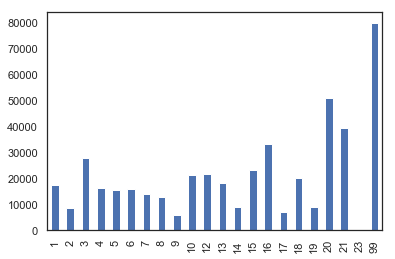

In [16]:
bills['majortopic'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [17]:
bills['majortopic'].value_counts().loc[23]

53

Not too unbalanced, except for topic label 23 (cultural bills), which has only 53 bills, whereas other topics all have $>5000$ bills.

 Drop topic 99 as outside main categories, and drop topic 23 as so few samples.

In [18]:
bills = bills[(bills['majortopic'] != 99) & (bills['majortopic']!=23)]

This leaves around 400,000 bills:

In [19]:
len(bills)

384401

and 20 topics:

In [20]:
dict_number_topic = {1: 'Macroeconomics',
                     2: 'Civil Rights',
                     3: 'Health',
                     4: 'Agriculture',
                     5: 'Labor',
                     6: 'Education',
                     7: 'Environment',
                     8: 'Energy',
                     9: 'Immigration',
                     10: 'Transportation',
                     12: 'Law and Crime',
                     13: 'Social Welfare',
                     14: 'Housing',
                     15: 'Domestic Commerce',
                     16: 'Defense',
                     17: 'Technology',
                     18: 'Foreign Trade',
                     19: 'International Affairs',
                     20: 'Government Operations',
                     21: 'Public Lands'
                    }

len(dict_number_topic)

20

### subtopic

counts of subtopics is much less balanced so will be harder to classify:

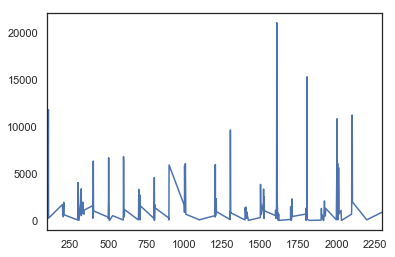

In [21]:
subtopic_count = bills['subtopic'].value_counts().sort_index()
subtopic_count.plot()
plt.show()

In [22]:
subtopic_count.median()

848.0

With half the subtopics having more than 848 bills, still have potential to look at the more common subtopics.

### bill titles

In [23]:
bills['description_length'] = bills['description'].str.len()
bills['description_nwords'] = bills['description'].str.split().str.len()

bills with short titles:

In [24]:
bills[bills['description_length']<20]

,description,majortopic,subtopic,description_length,description_nwords
7064,To decontrol sugar,4,402,18,3
26919,To raise revenue,10,1002,16,3
82153,For sailors.,16,1608,12,2
100907,x,20,2003,1,1
197292,Water Bank Act,10,1007,14,3
199024,Water Bank Act,10,1007,14,3
209431,Fish cancer study,4,405,17,3
228256,To end the war,16,1619,14,4
261650,Postal Reform Act,20,2003,17,3
273116,Bentsen,9,900,7,1


Can see several acronyms - fairly extensive list here https://noahveltman.com/acronyms/#words?word=EACH

distribution of number of words:

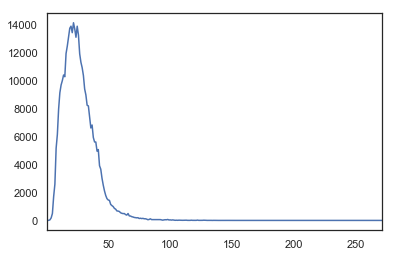

In [25]:
nwords_counts = bills['description_nwords'].value_counts().sort_index()
nwords_counts.plot()
plt.show()

long tail - variable length of bill titles may be tricky for some models

## Prepare for model - tokenize

Tokenize - **tokens** is without stopwords and **tokens_complete** is with stopwords:

In [26]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def tokenize_doc(doc, complete=False):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    
    # filter stopwords out of document
    if complete:
        return tokens
    else:
        filtered_tokens = [token for token in tokens if token not in stop_words]
        return filtered_tokens

bills['tokens'] = bills['description'].apply(tokenize_doc)
bills['tokens_complete'] = bills['description'].apply(tokenize_doc, complete=True)

In [27]:
# re-create decription from filtered tokens
bills['norm_description'] = bills['tokens'].str.join(' ')
bills['norm_description_complete'] = bills['tokens_complete'].str.join(' ')

In [28]:
bills.head(3)

,description,majortopic,subtopic,description_length,description_nwords,tokens,tokens_complete,norm_description,norm_description_complete
3,To increase the rates of certain educational and readjustment allowances payable to veterans in order to compensate for the higher cost of living in Alaska,6,601,155,25,"[increase, rates, certain, educational, readjustment, allowances, payable, veterans, order, compensate, higher, cost, living, alaska]","[to, increase, the, rates, of, certain, educational, and, readjustment, allowances, payable, to, veterans, in, order, to, compensate, for, the, higher, cost, of, living, in, alaska]",increase rates certain educational readjustment allowances payable veterans order compensate higher cost living alaska,to increase the rates of certain educational and readjustment allowances payable to veterans in order to compensate for the higher cost of living in alaska
4,To encourage enterprise capital investment in private business and aid industrial preparedness for national emergencies by abolishing mandatory depreciation deductions in loss years and permitting reduced depreciation deductions in low income years for Fe,1,100,255,34,"[encourage, enterprise, capital, investment, private, business, aid, industrial, preparedness, national, emergencies, abolishing, mandatory, depreciation, deductions, loss, years, permitting, reduced, depreciation, deductions, low, income, years, fe]","[to, encourage, enterprise, capital, investment, in, private, business, and, aid, industrial, preparedness, for, national, emergencies, by, abolishing, mandatory, depreciation, deductions, in, loss, years, and, permitting, reduced, depreciation, deductions, in, low, income, years, for, fe]",encourage enterprise capital investment private business aid industrial preparedness national emergencies abolishing mandatory depreciation deductions loss years permitting reduced depreciation deductions low income years fe,to encourage enterprise capital investment in private business and aid industrial preparedness for national emergencies by abolishing mandatory depreciation deductions in loss years and permitting reduced depreciation deductions in low income years for fe
5,"To continue rent control until June 30, 1950, and for other purposes",14,1406,68,12,"[continue, rent, control, june, purposes]","[to, continue, rent, control, until, june, and, for, other, purposes]",continue rent control june purposes,to continue rent control until june and for other purposes


In [29]:
from nltk.util import ngrams

all_words = [word for tokens in bills["tokens"] for word in tokens]
VOCAB = sorted(set(ngrams(all_words, 1)))
sentence_lengths = [len(tokens) for tokens in bills["tokens_complete"]]
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("1-grams: %s" % len(VOCAB))
print("2-grams: %s" % len(set(ngrams(all_words, 2))))
print("3-grams: %s" % len(set(ngrams(all_words, 3))))
print("4-grams: %s" % len(set(ngrams(all_words, 4))))
print("Max sentence length is %s" % max(sentence_lengths))

5688064 words total, with a vocabulary size of 49977
1-grams: 49977
2-grams: 691130
3-grams: 1512071
4-grams: 2173498
Max sentence length is 263


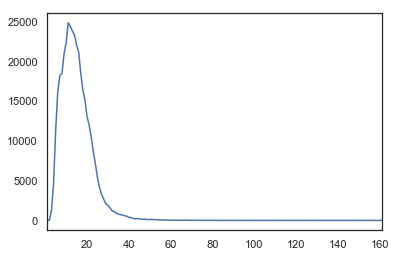

In [30]:
bills['description_ntokens'] = bills['tokens'].str.len()
ntokens_counts = bills['description_ntokens'].value_counts().sort_index()
ntokens_counts.plot()
plt.show()

#### Document frequency of common words

Look at the most common words excepting the stop words:

In [31]:
doc_words = [word for tokens in bills["tokens"] for word in set(tokens)]
pd.Series(doc_words).value_counts()[:30]

bill         177764
amend        167854
act          118295
provide      107913
purposes     107686
states       77245 
certain      72909 
united       67730 
code         67692 
title        53704 
federal      46403 
authorize    35648 
revenue      35154 
internal     34592 
national     34017 
establish    28118 
security     26746 
program      25110 
service      24973 
public       22643 
state        21868 
secretary    21826 
social       21788 
tax          21138 
section      20024 
require      18463 
health       18269 
income       17617 
benefits     17056 
services     16741 
dtype: int64

The most common words all appear relevant. 

Note that stop words are not included here. Sometimes frequency of stop words can indicate stylistic differences between difference document classes, but trying to add them back in using **tokens_complete** worsened results. So we'll use **tokens**, which excludes the stop words, for the analysis below.

# Model - Bag of Words

## Metric

Use f1_macro for scoring. This will optimize the average of f1 score for the different classes, so is useful when you want to get high precision and recall for every class. Averaging the f1 score over the classes is only problematic if the classes are highly imbalanced, which is not the case here.

## train-val-test

train-validation-test split:

In [32]:
list_labels = bills["majortopic"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    bills.drop(columns='majortopic'),
    list_labels,
    test_size=0.2,
    stratify=list_labels,
    random_state=42
)

# define the split explicitly to pass into GridSearchCV
single_split_cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in single_split_cv.split(X_train_val, y_train_val):
    X_train, y_train = X_train_val.iloc[train_index], y_train_val.iloc[train_index]
    X_val, y_val = X_train_val.iloc[val_index], y_train_val.iloc[val_index]

In [33]:
description = "norm_description" # excluding stop words works best, norm_description_complete for with stop words

norm_train_val = X_train_val[description]
norm_train = X_train[description]
norm_val = X_val[description]
norm_test = X_test[description]

## GridSearch

Try various parameter combinations in a pipeline (see code comments in next cell for more details). Here present the results showing the main differences, which come from the number of ngrams and the regularization parameter alpha for linear SVM.

In [34]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),
#         ('tfidf', TfidfTransformer()), # doesn't help (see param grid)
#         ('scaler', StandardScaler(with_mean=False)), # doesn't help convergence of sgd
        ('sgd', SGDClassifier(max_iter=30, tol=1e-3, random_state=42))
    ])

param_grid = {
#       'vectorizer__min_df': [1, 2, 3], # 1 is best
#       'vectorizer__max_df': [100000, 150000, 1.0], # not important
      'vectorizer__ngram_range': [(1,2), (1,3), (1,4)],
#       'vectorizer__binary': [False, True], # making features binary does not help
#       'tfidf__use_idf': [False, True], # tfidf weighting doesn't help
#       'tfidf__norm': [None, 'l2'], # normalizing each doc doesn't help
#       'sgd__penalty': ['l2', 'elasticnet'], # the default l2 is best
#       'sgd__loss': ['hinge', 'log'], # does not make too much difference, hinge slightly better
#       'sgd__class_weight': ['balanced', None], # None slightly better
      'sgd__alpha': [0.0001, 0.00001]
}

In [35]:
param_grid

{'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
 'sgd__alpha': [0.0001, 1e-05]}

In [36]:
gs_clf = GridSearchCV(pipeline, 
                      param_grid, 
                      cv=single_split_cv,
                      scoring='f1_macro',
                      n_jobs=-1, verbose=1,
                      return_train_score=True, refit=False)

In [37]:
%%time
gs_clf.fit(norm_train_val, y_train_val)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Wall time: 1min 51s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...om_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)], 'sgd__alpha': [0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring='f1_macro', verbose=1)

In [38]:
params = gs_clf.cv_results_['params']
val_scores = gs_clf.cv_results_['mean_test_score']
train_scores = gs_clf.cv_results_['mean_train_score']

In [39]:
gs_clf_results = pd.DataFrame(params)
gs_clf_results['f1_macro_val'] = val_scores
gs_clf_results['f1_macro_train'] = train_scores
gs_clf_results['train-val_divergence'] = train_scores - val_scores
gs_clf_results.sort_values('f1_macro_val', ascending=False).head(10)

,sgd__alpha,vectorizer__ngram_range,f1_macro_val,f1_macro_train,train-val_divergence
2,0.00010,"(1, 4)",0.869810,0.951955,0.082145
1,0.00010,"(1, 3)",0.869309,0.941126,0.071818
4,0.00001,"(1, 3)",0.863467,0.964520,0.101053
5,0.00001,"(1, 4)",0.862798,0.966581,0.103783
3,0.00001,"(1, 2)",0.862565,0.956793,0.094227
0,0.00010,"(1, 2)",0.862072,0.917233,0.055162


Choosing between these models is a question of balancing overfitting, as indicated by train-val_divergence, and the f1_macro_val validation score.

Given the very marginal improvement in moving to 4-grams, choose:

In [40]:
params = {'sgd__alpha': 0.0001, 'vectorizer__ngram_range': (1, 3)}

In [41]:
clf = pipeline
clf.set_params(**params)
clf

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
       ...om_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

## Results

### f1 score, accuracy, confusion matrix

In [42]:
clf.fit(norm_train, y_train)
y_train_predicted = clf.predict(norm_train)
y_val_predicted = clf.predict(norm_val)

In [43]:
f1_score(y_val, y_val_predicted, average='macro')

0.8693085684945068

In [44]:
accuracy_score(y_val, y_val_predicted)

0.8751463319458896

Normalized confusion matrix


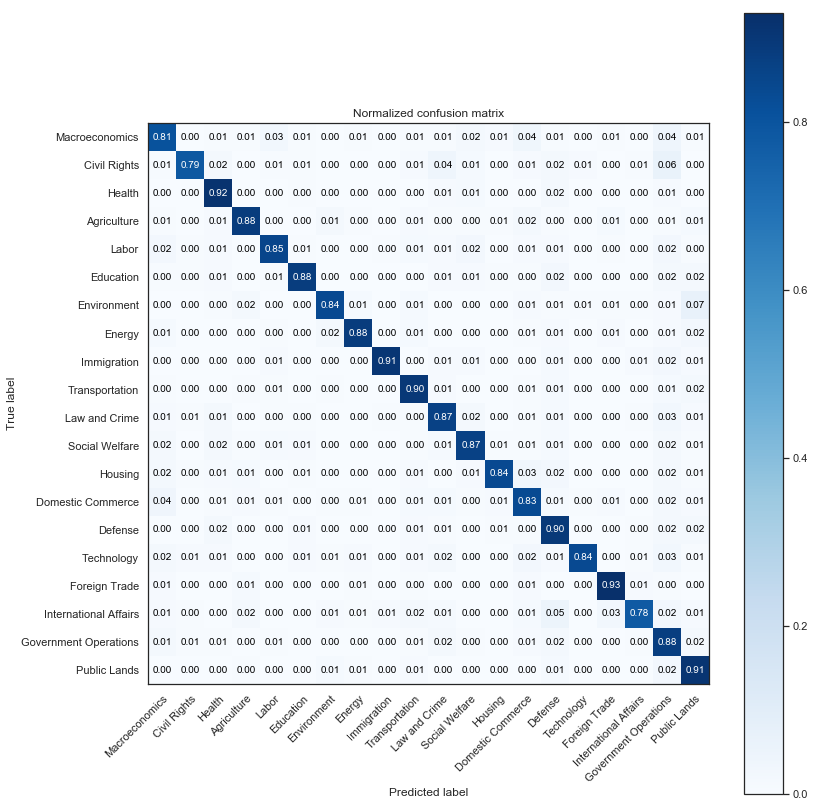

In [45]:
plot_confusion_matrix(y_val, y_val_predicted, 
                      classes=np.asarray(list(dict_number_topic.values())),
                      normalize=True)
plt.show()

- Bag of words with a linear SVM classifier is performing very well
- As there are 400,000 instances, it has been possible to fit the many features that arise from a bag-of-words representation
- And with so many features, the documents are separable with a linear model

### Top features

In [46]:
eli5.show_weights(clf.named_steps['sgd'],
                  vec=clf.named_steps['vectorizer'],
                  top=10,
                  target_names=dict_number_topic
                  )

- the model appears to be choosing sensible features, and features that are not overly fitted to the dataset.
- many of the features are common words, for example 'health' in the 'health' topic. In the EDA section above, we found that 'health' is also one of the top 30 most common words
- many features being common words helps explain why tf-idf weighting performs worse (in the grid search): tfidf would downweight these words, which you don't want to do. Also, we already removed the stop words, giving less need for tf-idf

### Mistaken classification - error types

In [47]:
mask = (y_val!=y_val_predicted)
df_errors = pd.DataFrame(norm_val[mask])
df_errors['actual'] = y_val[mask]
df_errors['predicted']  = y_val_predicted[mask]
df_errors['actual_topic'] = df_errors['actual'].map(dict_number_topic)
df_errors['predicted_topic'] = df_errors['predicted'].map(dict_number_topic)

pick the worst performing topics

In [48]:
cm = confusion_matrix(y_val, y_val_predicted)
worst_topics_accuracy = np.sort(np.diag(cm / cm.sum(axis=1)))
worst_topics = np.argsort(np.diag(cm / cm.sum(axis=1))) + 1

In [49]:
for i, topic in enumerate(worst_topics[:3]):
    print('Examples for topic: %s' % dict_number_topic[topic])
    print('Overall accuracy: %.2f\n' % worst_topics_accuracy[i])
    df_errors_topic = df_errors[df_errors['actual']==topic].sample(n=2, random_state=42)
    for j, (_, row) in enumerate(df_errors_topic.iterrows()):
        print('Example %d.%d ' % (i + 1, j + 1))
        print('True Label and Score, followed by Predicted Label and Score')
        display(eli5.show_prediction(clf.named_steps['sgd'],
                    row['norm_description'],
                    vec=clf.named_steps['vectorizer'],
                    target_names=dict_number_topic,
                    targets=[row['actual'], row['predicted']])
               )
    print('*'*75, '\n')

Examples for topic: Foreign Trade
Overall accuracy: 0.78

Example 1.1 
True Label and Score, followed by Predicted Label and Score


Example 1.2 
True Label and Score, followed by Predicted Label and Score


*************************************************************************** 

Examples for topic: Civil Rights
Overall accuracy: 0.79

Example 2.1 
True Label and Score, followed by Predicted Label and Score


Example 2.2 
True Label and Score, followed by Predicted Label and Score


*************************************************************************** 

Examples for topic: Macroeconomics
Overall accuracy: 0.81

Example 3.1 
True Label and Score, followed by Predicted Label and Score


Example 3.2 
True Label and Score, followed by Predicted Label and Score


*************************************************************************** 



From this and other examples, there are several types of error:
- not weighting key words heavily enough: averaging over all features means the model does not pick up the overriding importance of some key features
- not understanding the importance of absence: for example with misclassified international affairs examples, often there is no mention of foreign countries
- overall meaning: understanding the sentence meaning, rather than focusing on key words, explains the true topic
- overlapping categories: some of the misclassifications appear reasonable or sometimes even improved

To take the model further, a reasonable approach would be to look at 100 examples of mistaken prediction, and find out which type of error is most common, and then address that error.

## PCA

See if PCA on the bag-of-words features offers some insights:

In [50]:
lsa = TruncatedSVD(n_components=2)
lsa.fit(clf.named_steps['vectorizer'].transform(norm_train))

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [51]:
_, norm_graph, _, y_graph = train_test_split(norm_train, y_train, test_size=500,
                                                    stratify=y_train)
lsa_scores = lsa.transform(clf.named_steps['vectorizer'].transform(norm_graph))

In [52]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_graph.values[i]),
                 color=plt.cm.Set1(y_graph.values[i] / 21.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

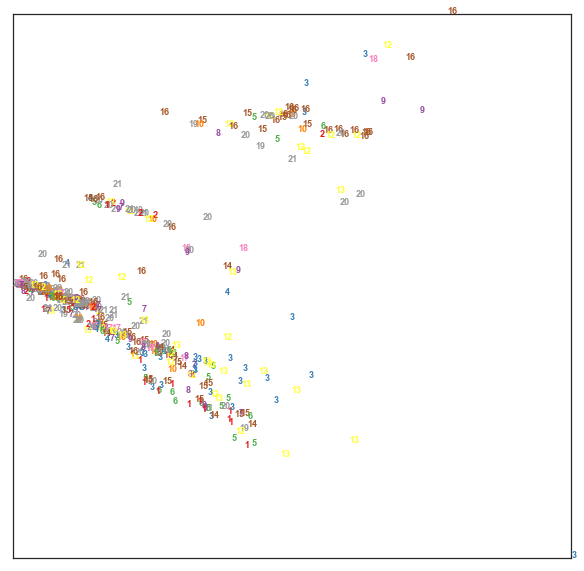

In [53]:
plot_embedding(lsa_scores)

Interestingly, very poor separation. Probably because:
- much of the variance in the bag-of-words representation is in common words (whose frequency has a wider distribution) that do not have much predictive power.
- hence the first 2 components of PCA capture the variance in these common words, but fail to capture the (smaller) variance of the uncommon words that have predictive power.

This also supports the observation above that it is the high dimensional representation that enables linear models to separate the classes.

# Model - Average of word embeddings

In [33]:
with open('config.txt') as f:
    embedding_path = Path(f.readline())
    f.close

word2vec and GloVe embeddings give similar results. Here take the GloVe emeddings:

In [34]:
EMBEDDING_DIM = 300
glove_file = 'glove.6B.' + str(EMBEDDING_DIM) + 'd.txt'

if 'glove' not in locals():
    glove = {}
    with open(embedding_path / glove_file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            glove[word] = coefs

print('Found %s word vectors.' % len(glove))

# for word2vec
# import gensim
# word2vec_path = embedding_path / "GoogleNews-vectors-negative300.bin.gz"
# if 'word2vec' not in locals():
#     word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

Found 400000 word vectors.


In [35]:
def get_average_embedding(tokens_list, vector, generate_missing=False, k=EMBEDDING_DIM):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_embeddings(vectors, bills, generate_missing=False):
    embeddings = bills['tokens'].apply(
        lambda x: get_average_embedding(x, vectors, generate_missing=generate_missing)
                                      )
    return list(embeddings)

In [36]:
X_train_e = get_embeddings(glove, X_train)
X_val_e = get_embeddings(glove, X_val)

In [37]:
sgd_clf_e = SGDClassifier(max_iter=30, tol=1e-3, random_state=42)
sgd_clf_e.fit(X_train_e, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=30,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
y_val_predicted_e = sgd_clf_e.predict(X_val_e)
f1_score(y_val, y_val_predicted_e, average='macro')

0.7286928022237875

- averaging GloVe or word2vec embeddings turns out to give noticeably poorer performance for this problem
- there are several ways to squeeze more out of basic word embeddings (see https://openreview.net/forum?id=SyK00v5xx or https://github.com/UKPLab/arxiv2018-xling-sentence-embeddings)
- but there are now better ways to generate embeddings for sentences, which we return to in the next notebook.

# Model - Deep Learning - CNN

In [60]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical

from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, Embedding
from keras.models import Sequential, Model

Using TensorFlow backend.


In [65]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(bills["description"])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 49622 unique tokens.


Document length has an extreme tail, as discussed in the exploratory data analysis. Extreme padding will make it hard to train a CNN. To start with, take the first 20 words of each document.

In [86]:
X_train["tokens20"] = X_train["tokens"].apply(lambda x: x[:20])
X_val["tokens20"] = X_val["tokens"].apply(lambda x: x[:20])

X_train["description20"] = X_train["tokens20"].str.join(' ')
X_val["description20"] = X_val["tokens20"].str.join(' ')

train_k = tokenizer.texts_to_sequences(X_train["description20"])
val_k = tokenizer.texts_to_sequences(X_val["description20"])

In [71]:
MAX_SEQUENCE_LENGTH = 20
padding = 'post'
truncating = 'post'

train = pad_sequences(train_k, maxlen=MAX_SEQUENCE_LENGTH, padding=padding, truncating=truncating)
val = pad_sequences(val_k, maxlen=MAX_SEQUENCE_LENGTH, padding=padding, truncating=truncating)

for the labels, need to have topic numbers from 0:

In [67]:
nconvert_keys = sorted(bills['majortopic'].unique())
nconvert_values = range(len(nconvert_keys))
dict_nconvert = dict(zip(nconvert_keys, nconvert_values))

y_train0 = y_train.map(dict_nconvert)
y_val0 = y_val.map(dict_nconvert)

y_train_cat = to_categorical(y_train0)
y_val_cat = to_categorical(y_val0)

In [72]:
train.shape, y_train_cat.shape

((246016, 20), (246016, 20))

In [73]:
EMBEDDING_DIM = 300
embedding_choice = glove

# rows of embedding_weights are vector embedding for each of the words in word_index
embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = embedding_choice[word] if word in embedding_choice else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

(49623, 300)


In [74]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_weights],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [75]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
print(sequence_input)

Tensor("input_1:0", shape=(?, 20), dtype=int32)


Try a multi-layer CNN:

In [78]:
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 2, activation='relu')(embedded_sequences)
x = Conv1D(128, 2, activation='relu')(x)
x = Conv1D(128, 2, activation='relu')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(20, activation='softmax')(x)

In [79]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 300)           14886900  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 19, 128)           76928     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 18, 128)           32896     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 17, 128)           32896     
_________________________________________________________________
flatten_2 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               278656    
__________

In [81]:
%%time
history = model.fit(train,
                    y_train_cat, 
                    validation_data=(val, y_val_cat),
                    epochs=10, batch_size=128)

Train on 246016 samples, validate on 61504 samples
Epoch 1/10
246016/246016 [==============================] - 14s 58us/step - loss: 1.6683 - acc: 0.5276 - val_loss: 1.1737 - val_acc: 0.6805
Epoch 2/10
246016/246016 [==============================] - 12s 51us/step - loss: 1.0297 - acc: 0.7161 - val_loss: 0.9420 - val_acc: 0.7408
Epoch 3/10
246016/246016 [==============================] - 13s 51us/step - loss: 0.8393 - acc: 0.7676 - val_loss: 0.8368 - val_acc: 0.7711
Epoch 4/10
246016/246016 [==============================] - 13s 51us/step - loss: 0.7345 - acc: 0.7947 - val_loss: 0.8008 - val_acc: 0.7846
Epoch 5/10
246016/246016 [==============================] - 13s 51us/step - loss: 0.6593 - acc: 0.8131 - val_loss: 0.8214 - val_acc: 0.7769
Epoch 6/10
246016/246016 [==============================] - 13s 51us/step - loss: 0.6043 - acc: 0.8273 - val_loss: 0.8437 - val_acc: 0.7771
Epoch 7/10
246016/246016 [==============================] - 13s 53us/step - loss: 0.5529 - acc: 0.8393 - val_

In [82]:
def plot_learning_curve(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.subplots_adjust(top=0.85, wspace=0.3)

    epochs = len(history.epoch)
    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

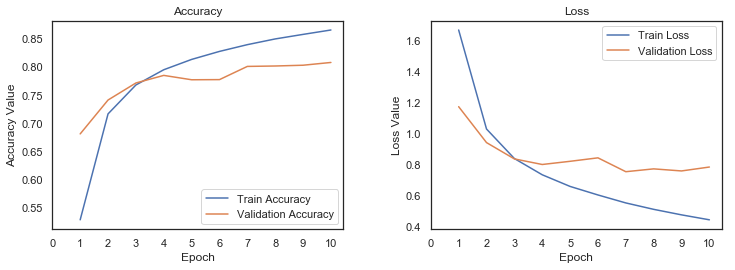

In [83]:
plot_learning_curve(history)

In [84]:
y_val_prob = model.predict(val)
y_val_predict = y_val_prob.argmax(axis=-1)
f1_score(y_val_predict, y_val_cat.argmax(axis=-1), average='macro')

0.7953483997451658

# Summary

Bag of words with linear models:
- bag of words currently has the best performance
- tf-idf does not improve results, as there are common words, appearing in numerous documents, that have predictive power and it is better not to downweight these words
- as 400,000 is a reasonable number of instances, it is possible to fit the many features that result from a bag-of-words representation
- having many features means the data can be linearly separated. What worked best was a linear SVM (hinge loss, and one-versus-all) classifier

Word embeddings:
- word2vec or GloVe and averaging over the word embeddings gives a weak sentence respresentation, which lags behind the other 2 approaches
- the poor separation of PCA with 2 components versus the high performance of a linear classifier with many features suggests we need a high dimensional feature space

Deep learning:
- a first simple attempt at a neural network architecture shows promising results, tbc...